In [1]:
import numpy as np
from Bandits2 import Bandits
import matplotlib.pyplot as plt

In [ ]:
def linucb_fairness40(self, ind=[], max_T=500, steps=25, seed=0, la=0.16, delta=0.12, noisef=0.1, repeats=20, 
                    eps=[0.25], beta=[1], q_p=[0.2], q_w=[1], wid=[1], plots=[0, 1]):
    np.random.seed(seed)
    ret_ = [[], []]
    noise = np.mean(self.rewards) * noisef
    func = {0: self.LinUCB, 1: self.LinUCB_eps_greedy, 2: self.LinUCB_cost, 3: self.LinUCB_queue, -3: self.LinUCB_queue, 4: self.LinUCB_fairbounds}
    func_name = {0: "Linear UCB", 1: "ε-greedy", 2: "Diversity Cost", 3: "Queue", -3:"Queue", 4: "Fair Bounds"}
    hp = {0: [""], 1: eps, 2: beta, 3: q_p, -3: q_w, 4: wid}
    labe = {0: "", 1: ", ε=", 2: ", β=", 3: ", q_p=", -3: ", q_w=", 4: ", w="}
    param = {0: [{"T": max_T, "steps":steps}],
             1: [{"T": max_T, "steps":steps, "eps":ep} for ep in eps],
             2: [{"T": max_T, "steps":steps, "beta":b} for b in beta],
             3: [{"T": max_T, "steps":steps, "q_p":qp, "q_w":q_w[0]} for qp in q_p],
             -3: [{"T": max_T, "steps":steps, "q_p":q_p[0], "q_w":qw} for qw in q_w],
             4: [{"T": max_T, "steps":steps, "wid":w} for w in wid]}

    x = [int(np.floor(i * max_T / steps)) for i in range(1, steps+1)]
    y = {}
    con = {}
    freq = {}
    err = {}
    errcon = {}
    FSI = {}

    for i in ind:
        y[i] = [np.zeros((repeats, steps)) for l in range(len(param[i]))]
        con[i] = [np.zeros((repeats, steps)) for l in range(len(param[i]))]
        freq[i] = [np.zeros((self.C, self.K)) for l in range(len(param[i]))]
        err[i] = []
        errcon[i] = []
        FSI[i] = []
            
    assert len(np.unique(x)) == steps


    # Dependent variable (Regret)
    # Run algorithms
    for i in ind:
        for l in range(len(param[i])):
            for r in range(repeats):
                y[i][l][r] += np.array(func[i](la, delta, noise, fixed=[True, r], **param[i][l])[4])
                con[i][l][r] += self.run_logs[self.run_count-1]["Consistency"]
                ca = self.chosen_arms()

                # Update chosen arms
                for c in range(self.C):
                    freq[i][l][c] += ca[0][c]
    
            err[i].append(np.std(y[i][l], axis=0, ddof=1) / np.sqrt(repeats))
            errcon[i].append(np.std(con[i][l], axis=0, ddof=1) / np.sqrt(repeats))
    
            self.df = freq[i][l]/repeats
            print(func_name[i], hp[i][l], self.df)
            G = self.Gini_fairness()
            E = self.mix() + G
            FSI[i].append(E[0])
        

    for i in ind:
        for l in range(len(param[i])):
            ret_[0].append(np.sum(y[i][l], axis=0)/repeats)

    for i in ind:
        for l in range(len(param[i])):
            ret_[1].append(np.sum(con[i][l], axis=0)/repeats)

    return ret_

In [ ]:
def lf_400(K, d, C, p, alg=[0, 1, 2, 3], repe=10):
    func_name = {0: "Linear UCB", 1: "ε-greedy", 2: "Diversity Cost", 3: "Queue", -3:"Queue", 4: "Fair Bounds"}
    plot1y = []
    plot2y = []
    plot3y = []

    for seed in range(repe):
        A = Bandits(K=K, d=d, C=C, p=p, seed=seed)
        A.generate_context(max_T=100 * K * d**2 //9, repeats=10)
        print(f"seed={seed}a")
        a = A.rf_curve(alg=['eps-greedy', 'cost', 'queue', 'bounds'], max_T=100 * K * d**2 //9, la=0.16, delta=0.12, repeats=10, return_results=True)
        print(f"seed={seed}b")
        b = linucb_fairness40(A, ind=[1, 2, 3, 4], max_T=100 * K * d**2 //9, steps=25, seed=0, la=0.16, delta=0.12, noisef=0.1, repeats=10, 
                    eps=[A.greedy_eps], beta=[A.cost_beta], q_p=[A.queue_q_p], q_w=[1], wid=[A.bounds_wid])
        print(A.greedy_eps, A.cost_beta, A.queue_q_p, A.bounds_wid)
        plot1y.append(a)
        plot2y.append(b[0])
        plot3y.append(b[1])

    # Plot 1
    plt.figure()
    plot1y = np.array(plot1y)
    for i in alg:
        x1 = np.mean(plot1y[:, i, 1, :], axis=0)
        xerr1 = np.std(plot1y[:, i, 1, :], axis=0, ddof=1) / np.sqrt(10)
        y1 = np.mean(plot1y[:, i, 0, :], axis=0)
        yerr1 = np.std(plot1y[:, i, 0, :], axis=0, ddof=1) / np.sqrt(10)
        plt.errorbar(x1, y1, xerr=xerr1, yerr=yerr1, label=func_name[i+1], linestyle='-', marker='o', markersize=2)

    plt.grid()
    plt.legend()
    plt.ylabel("Fairness-Spread")
    plt.xlabel("Regret")
    plt.title("Relationship between fairness measure and regret")
    plt.show()


    # Plot 2
    plt.figure()
    plot2y = np.array(plot2y)
    x2 = [int(np.floor(i * 100 * K * d**2 //9 / 25)) for i in range(1, 25+1)]
    for i in alg:
        y2 = np.mean(plot2y[:, i, :], axis=0)
        yerr2 = np.std(plot2y[:, i, :], axis=0, ddof=1) / np.sqrt(10)
        plt.errorbar(x2, y2, yerr=yerr2, label=f"{func_name[i+1]}", linestyle='-', marker='x', markersize=2)
        
    plt.legend()
    plt.grid()
    plt.xlabel("Number of Iterations")
    plt.ylabel("Cumulative Regret")
    plt.title("Relationship between # of iterations and cumulative regret")
    plt.show()

    # Plot 3
    plt.figure()
    plot3y = np.array(plot3y)
    x3 = [int(np.floor(i * 100 * K * d**2 //9 / 25)) for i in range(1, 25+1)]
    for i in alg:
        y3 = np.mean(plot3y[:, i, :], axis=0)
        yerr3 = np.std(plot3y[:, i, :], axis=0, ddof=1) / np.sqrt(10)
        plt.errorbar(x3, y3, yerr=yerr3, label=f"{func_name[i+1]}", linestyle='-', marker='x', markersize=2)
    plt.legend()
    plt.grid()
    plt.xlabel("Number of Iterations")
    plt.ylabel("Consistency")
    plt.title("Relationship between # of iterations and consistency")
    plt.show()

    return None

## 1. Number of Arms

### 1.1 $K = 5$

seed=0a
0.14938015821857217
eps-greedy complete
0.14938015821857217
cost complete
0.14938015821857217
queue complete
0.14938015821857217
bounds complete
seed=0b
ε-greedy 2.6626535983207518 [[0.1402 0.1436 0.4058 0.1422 0.1682]]
Diversity Cost 46.96544401510517 [[0.1994 0.1864 0.2342 0.1872 0.1928]]
Queue 1.0620600901469115 [[0.176  0.1744 0.2998 0.1744 0.1754]]
Fair Bounds 1.757337348952385 [[0.1426 0.16   0.3878 0.1622 0.1474]]
2.6626535983207518 46.96544401510517 1.0620600901469115 1.757337348952385
seed=1a
0.14938015821857217
eps-greedy complete
0.14938015821857217
cost complete
0.14938015821857217
queue complete
0.14938015821857217
bounds complete
seed=1b
ε-greedy 1.5525281513748763 [[0.1174 0.086  0.0822 0.557  0.1574]]
Diversity Cost 8.987547014914806 [[0.2296 0.0426 0.1526 0.3416 0.2336]]
Queue 0.7031065168216248 [[0.1236 0.1216 0.1224 0.5032 0.1292]]
Fair Bounds 0.9607475339499287 [[0.124  0.0942 0.0984 0.557  0.1264]]
1.5525281513748763 8.987547014914806 0.7031065168216248 0.9

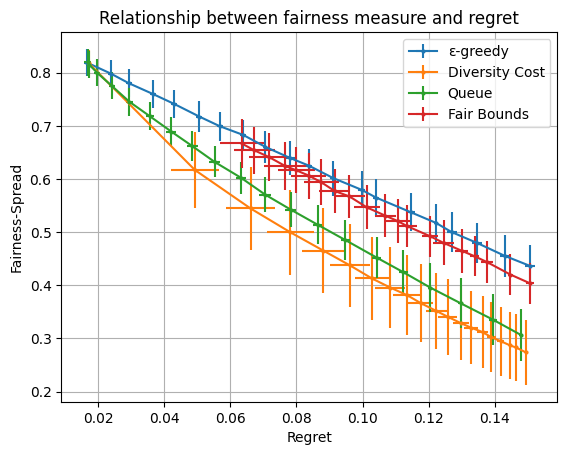

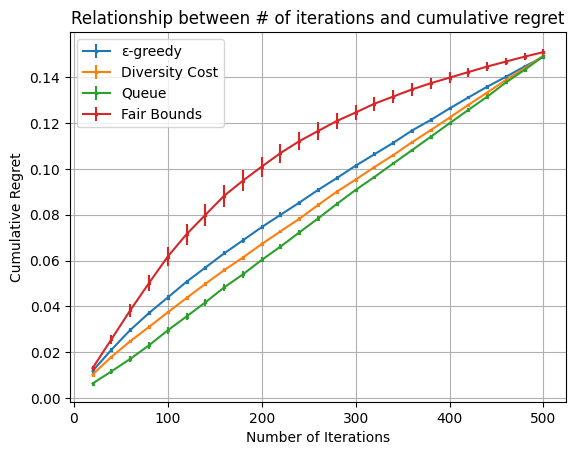

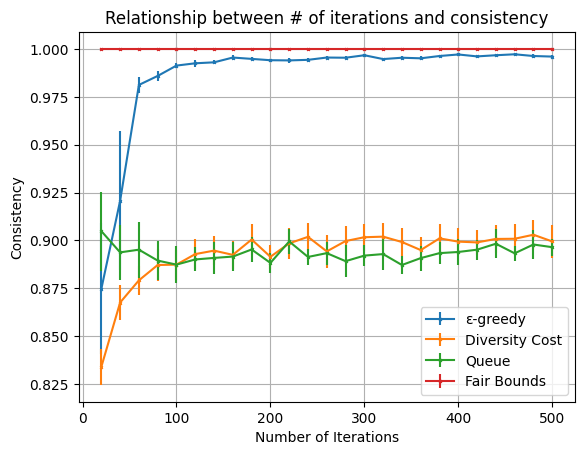

In [9]:
lf_400(5, 3, -1, 10, repe=10)

### 1.2 $K = 15$

seed=0a
0.14938015821857217
eps-greedy complete
0.14938015821857217
cost complete
0.14938015821857217
queue complete
0.14938015821857217
bounds complete
seed=0b
ε-greedy 1.5583906779699983 [[0.02766667 0.02786667 0.08353333 0.0272     0.03593333 0.02746667
  0.51406667 0.0316     0.02613333 0.056      0.02586667 0.02946667
  0.0334     0.02693333 0.02686667]]
Diversity Cost 21.04334995678535 [[0.0734     0.0238     0.137      0.06026667 0.08606667 0.0188
  0.1588     0.10733333 0.00453333 0.10613333 0.03033333 0.01053333
  0.11933333 0.01873333 0.04493333]]
Queue 0.5995674749004598 [[0.03866667 0.03866667 0.0554     0.03866667 0.03866667 0.03426667
  0.4512     0.03866667 0.038      0.03906667 0.03853333 0.0344
  0.03886667 0.03833333 0.0386    ]]
Fair Bounds 0.12333833118061563 [[0.0316     0.03153333 0.08213333 0.03253333 0.02986667 0.02753333
  0.49893333 0.034      0.02733333 0.0302     0.03553333 0.03626667
  0.04193333 0.03133333 0.02926667]]
1.5583906779699983 21.04334995678535 

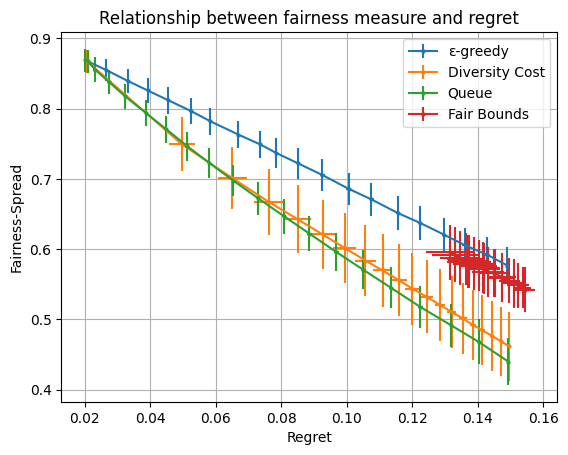

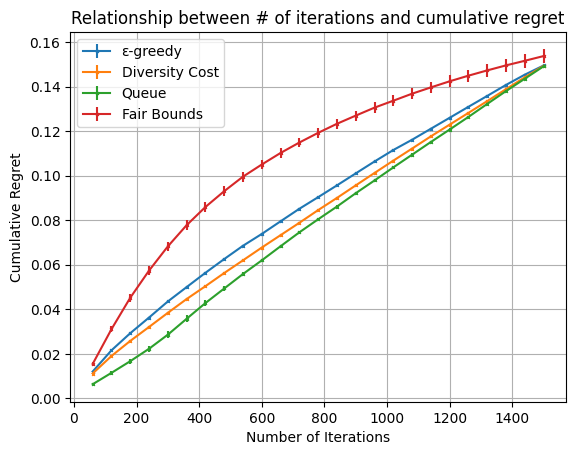

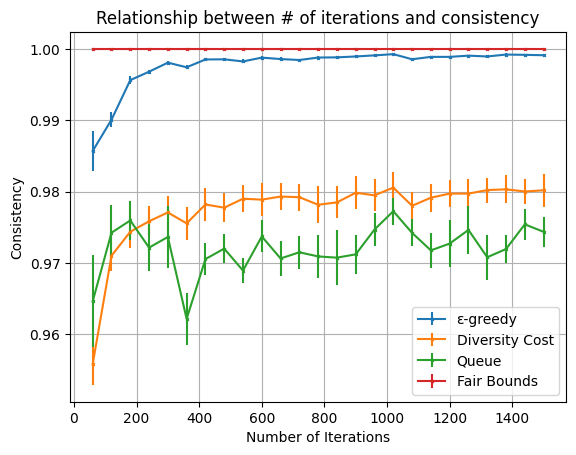

In [5]:
lf_400(15, 3, -1, 10, repe=10)

## 2. Dimension of Arms

### 2.1 $d=5$

seed=0a
0.12599210498948732
eps-greedy complete
0.12599210498948732
cost complete
0.12599210498948732
queue complete
0.12599210498948732
bounds complete
seed=0b
ε-greedy 4.8459360515384216 [[0.18040346 0.23645533 0.18076369 0.18782421 0.21455331]]
Diversity Cost 1515.8673573804615 [[0.19675793 0.20720461 0.19755043 0.19365994 0.20482709]]
Queue 1515.8673573804615 [[0.24582133 0.26974063 0.09841499 0.23184438 0.15417867]]
Fair Bounds 1.274669204676034 [[0.19769452 0.21613833 0.20237752 0.17154179 0.21224784]]
4.8459360515384216 1515.8673573804615 1515.8673573804615 1.274669204676034
seed=1a
0.12599210498948732
eps-greedy complete
0.12599210498948732
cost complete
0.12599210498948732
queue complete
0.12599210498948732
bounds complete
seed=1b
ε-greedy 1.499898896540888 [[0.06332853 0.06512968 0.07139769 0.07341499 0.72672911]]
Diversity Cost 2.047405022421565 [[0.03631124 0.05129683 0.22550432 0.15626801 0.5306196 ]]
Queue 0.4682843265931009 [[0.08523055 0.08530259 0.08573487 0.08566282 0

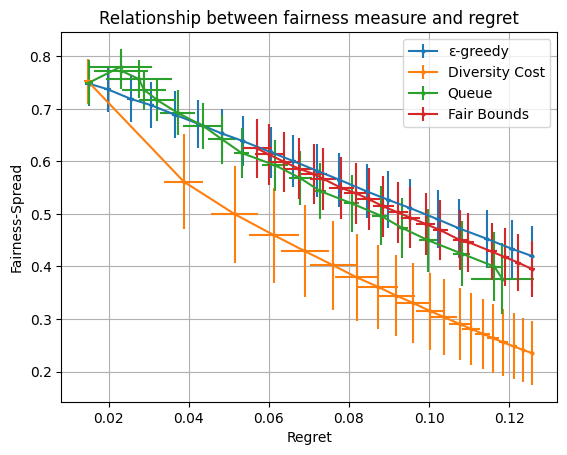

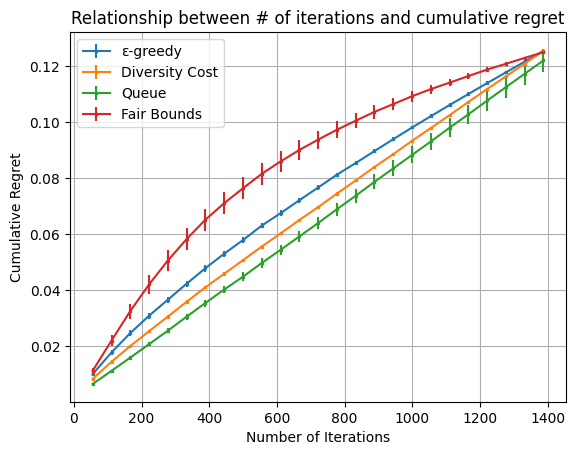

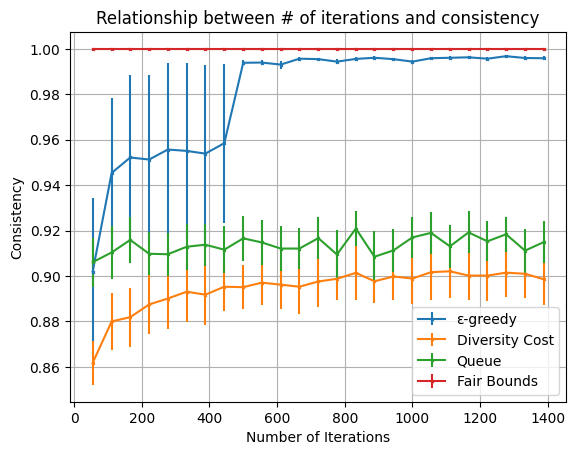

In [10]:
lf_400(5, 5, -1, 10, repe=10)

### 2.2 $d=10$

seed=0a
0.1
eps-greedy complete
0.1
cost complete
0.1
queue complete
0.1
bounds complete
seed=0b
ε-greedy 5.080164078613984 [[0.31369937 0.17465347 0.20482448 0.16608461 0.14073807]]
Diversity Cost 391.3555267302661 [[0.21164716 0.2020342  0.20648065 0.20284428 0.1769937 ]]
Queue 24.59690999358041 [[0.10356436 0.36707471 0.10171017 0.20327633 0.22437444]]
Fair Bounds 0.6934582169182865 [[0.24207021 0.21222322 0.22277228 0.21483348 0.10810081]]
5.080164078613984 391.3555267302661 24.59690999358041 0.6934582169182865
seed=1a
0.1
eps-greedy complete
0.1
cost complete
0.1
queue complete
0.1
bounds complete
seed=1b
ε-greedy 3.184536498182578 [[0.09189919 0.09387939 0.37693969 0.25893789 0.17834383]]
Diversity Cost 35.46065855238737 [[0.14523852 0.18379838 0.2340234  0.22527453 0.21166517]]
Queue 0.8337957183336022 [[0.14293429 0.14293429 0.34554455 0.22550855 0.14307831]]
Fair Bounds 0.3975554503880514 [[0.0740234  0.11492349 0.3829523  0.25868587 0.16941494]]
3.184536498182578 35.460658552

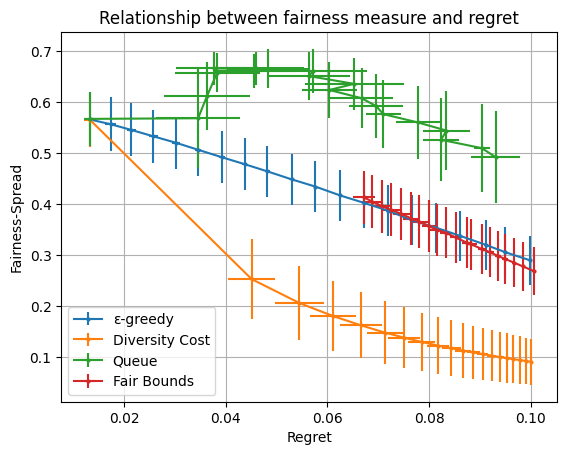

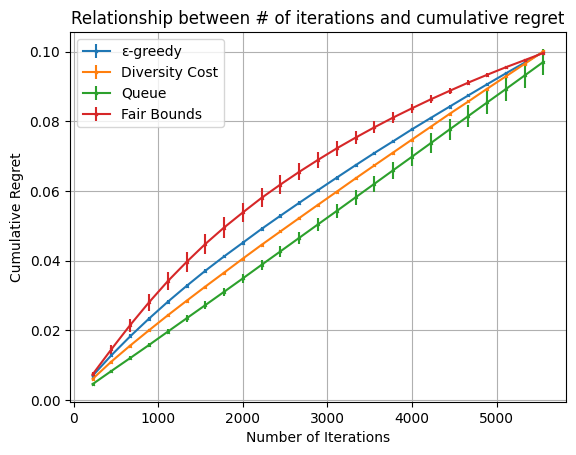

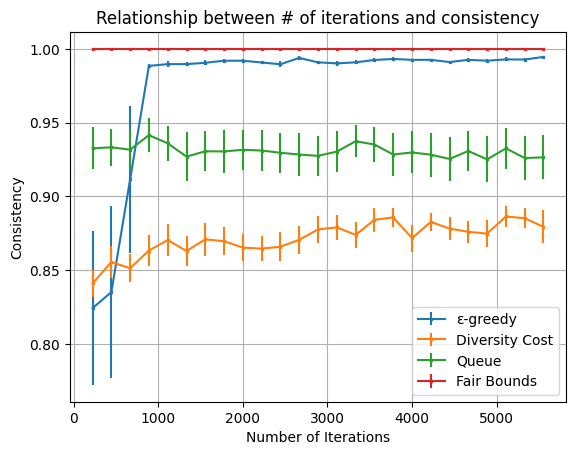

In [8]:
lf_400(5, 10, -1, 10, repe=10)

## 3. Number of Contexts

### 3.1 $C=30$

seed=0a
0.17387378769329517
eps-greedy complete
0.17387378769329517
cost complete
0.17387378769329517
queue complete
0.17387378769329517
bounds complete
seed=0b
ε-greedy 1.8467157966518561 [[0.10134208 0.07967208 0.10086931 0.11342666 0.60468987]
 [0.12317784 0.0882511  0.08455182 0.0985901  0.60542915]
 [0.06894231 0.12844988 0.06824786 0.07628108 0.65807887]
 [0.0929798  0.09080243 0.09028656 0.10334133 0.62258987]
 [0.08414513 0.1282851  0.14647356 0.09110793 0.54998828]
 [0.12891313 0.09649954 0.60336988 0.09506311 0.07615434]
 [0.08140774 0.09502232 0.09861676 0.14787658 0.5770766 ]
 [0.10033857 0.07253694 0.1218596  0.08862405 0.61664084]
 [0.08087366 0.05423816 0.0586826  0.08105745 0.72514813]
 [0.06581454 0.13102757 0.05933584 0.12737678 0.61644528]
 [0.06232466 0.11663174 0.06876374 0.12169567 0.6305842 ]
 [0.11047475 0.09481313 0.54836736 0.09718448 0.14916029]
 [0.10678356 0.13982843 0.12175151 0.09290158 0.53873492]
 [0.0841804  0.08352564 0.1250351  0.14119811 0.56606074]

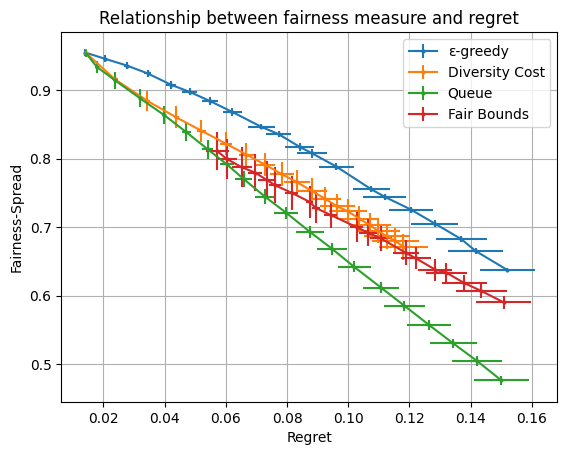

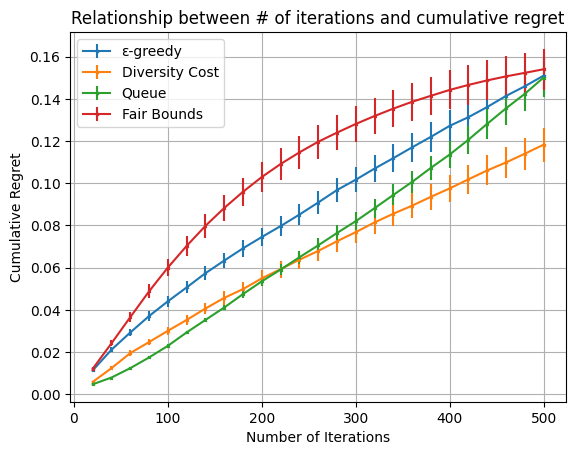

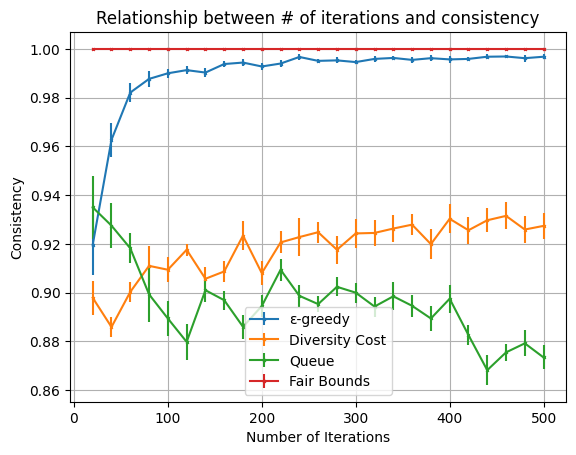

In [14]:
lf_400(5, 3, 30, 10, repe=10)

### 3.2 $C=5$

seed=0a
0.18470391784040177
eps-greedy complete
0.18470391784040177
cost complete
0.18470391784040177
queue complete
0.18470391784040177
bounds complete
seed=0b
ε-greedy 1.9151787713349337 [[0.11797609 0.60884718 0.09009575 0.10316335 0.07991763]
 [0.08811162 0.61316767 0.10118164 0.10053843 0.09700063]
 [0.10817304 0.59573827 0.09364717 0.0996059  0.10283561]
 [0.08556623 0.61141589 0.10150932 0.10953191 0.09197665]
 [0.0944934  0.57668308 0.10535149 0.11802709 0.10544495]]
Diversity Cost 142.85887392643502 [[0.01048256 0.41044288 0.29681782 0.02220657 0.26005017]
 [0.04309046 0.39333869 0.30212323 0.01263755 0.24881007]
 [0.04084857 0.42433481 0.29670658 0.01839937 0.21971066]
 [0.01049667 0.41145479 0.28196807 0.05048261 0.24559786]
 [0.01118163 0.37828828 0.2396855  0.08325228 0.2875923 ]]
Queue 0.6489962433033745 [[0.07272191 0.59194983 0.11669691 0.10378913 0.11484221]
 [0.07495225 0.59466406 0.11553356 0.10025115 0.11459898]
 [0.07427376 0.59005776 0.11673886 0.10427976 0.114649

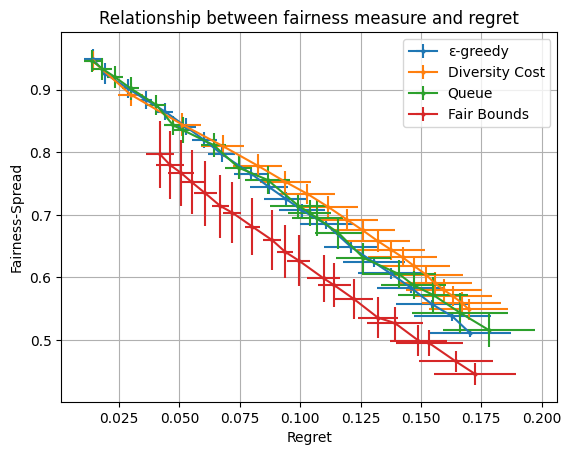

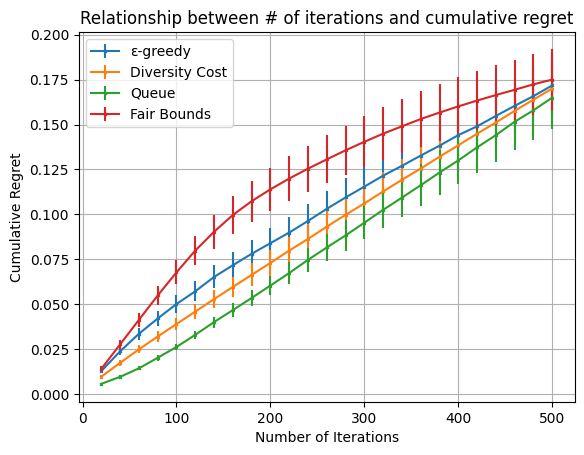

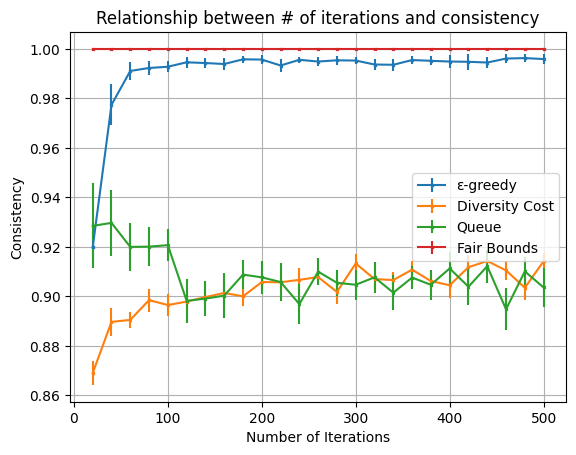

In [12]:
lf_400(5, 3, 5, 10, repe=10)